In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
import time
import random

In [3]:

from IPython.display import Markdown, display
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, svm

%matplotlib inline
rnd_seed_state = 1

In [40]:
from sqlalchemy import create_engine

In [4]:
#The first step is the initial general pre-execution configuration of the notebook
def pre_config():
    """
    Does initial general pre-execution configuration.
    """
    plt.rcParams.update({'font.size': 20})
    random.seed(rnd_seed_state)

In [7]:
#read in csv file with all MutualFunds, display first 5 rows
df1 = pd.read_csv('/Users/isidorakujundzic/Project-description/data/MutualFunds.csv')



In [8]:
def hist_bar_plot(df, rc_num=(2, 6), size=(16 * 3, 9 * 3), unique=True):
    """
    Creates histogram and bar visualizations for 
    a given DataFrame. Depending on the DataFrame 
    attribute type, numerical or categorical, it 
    creates a histogram or bar plot respectively.
    
    Arguments:
        df: Dataset pandas DataFrame.
        rc_num: Number of rows and columns.
        size: Size of the plot.
        unique: If True, it reduces the number of 
        attributes that will be visualized using 
        the number of unique values as a heuristic.
    """
    # Chose adequate columns for visualization
    if unique:
        num_unique_col = df.nunique()
        df = df[[col for col in df if 1 < num_unique_col[col] < 50]]

    # Create Hist and Bar plots
    plt.figure(figsize=size)
    for i, col in enumerate(df):
        plt.subplot(rc_num[0], rc_num[1], i + 1)
        df_column = df[col]
        if np.issubdtype(type(df_column.iloc[0]), np.number):
            df_column.hist()
        else:
            df_column.value_counts().plot.bar()
        plt.title(col, fontsize=25)
        plt.xticks(rotation=30, fontsize=30)
        plt.yticks(fontsize=30)
        plt.ylabel('counts')

        if i == 10:
            break
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

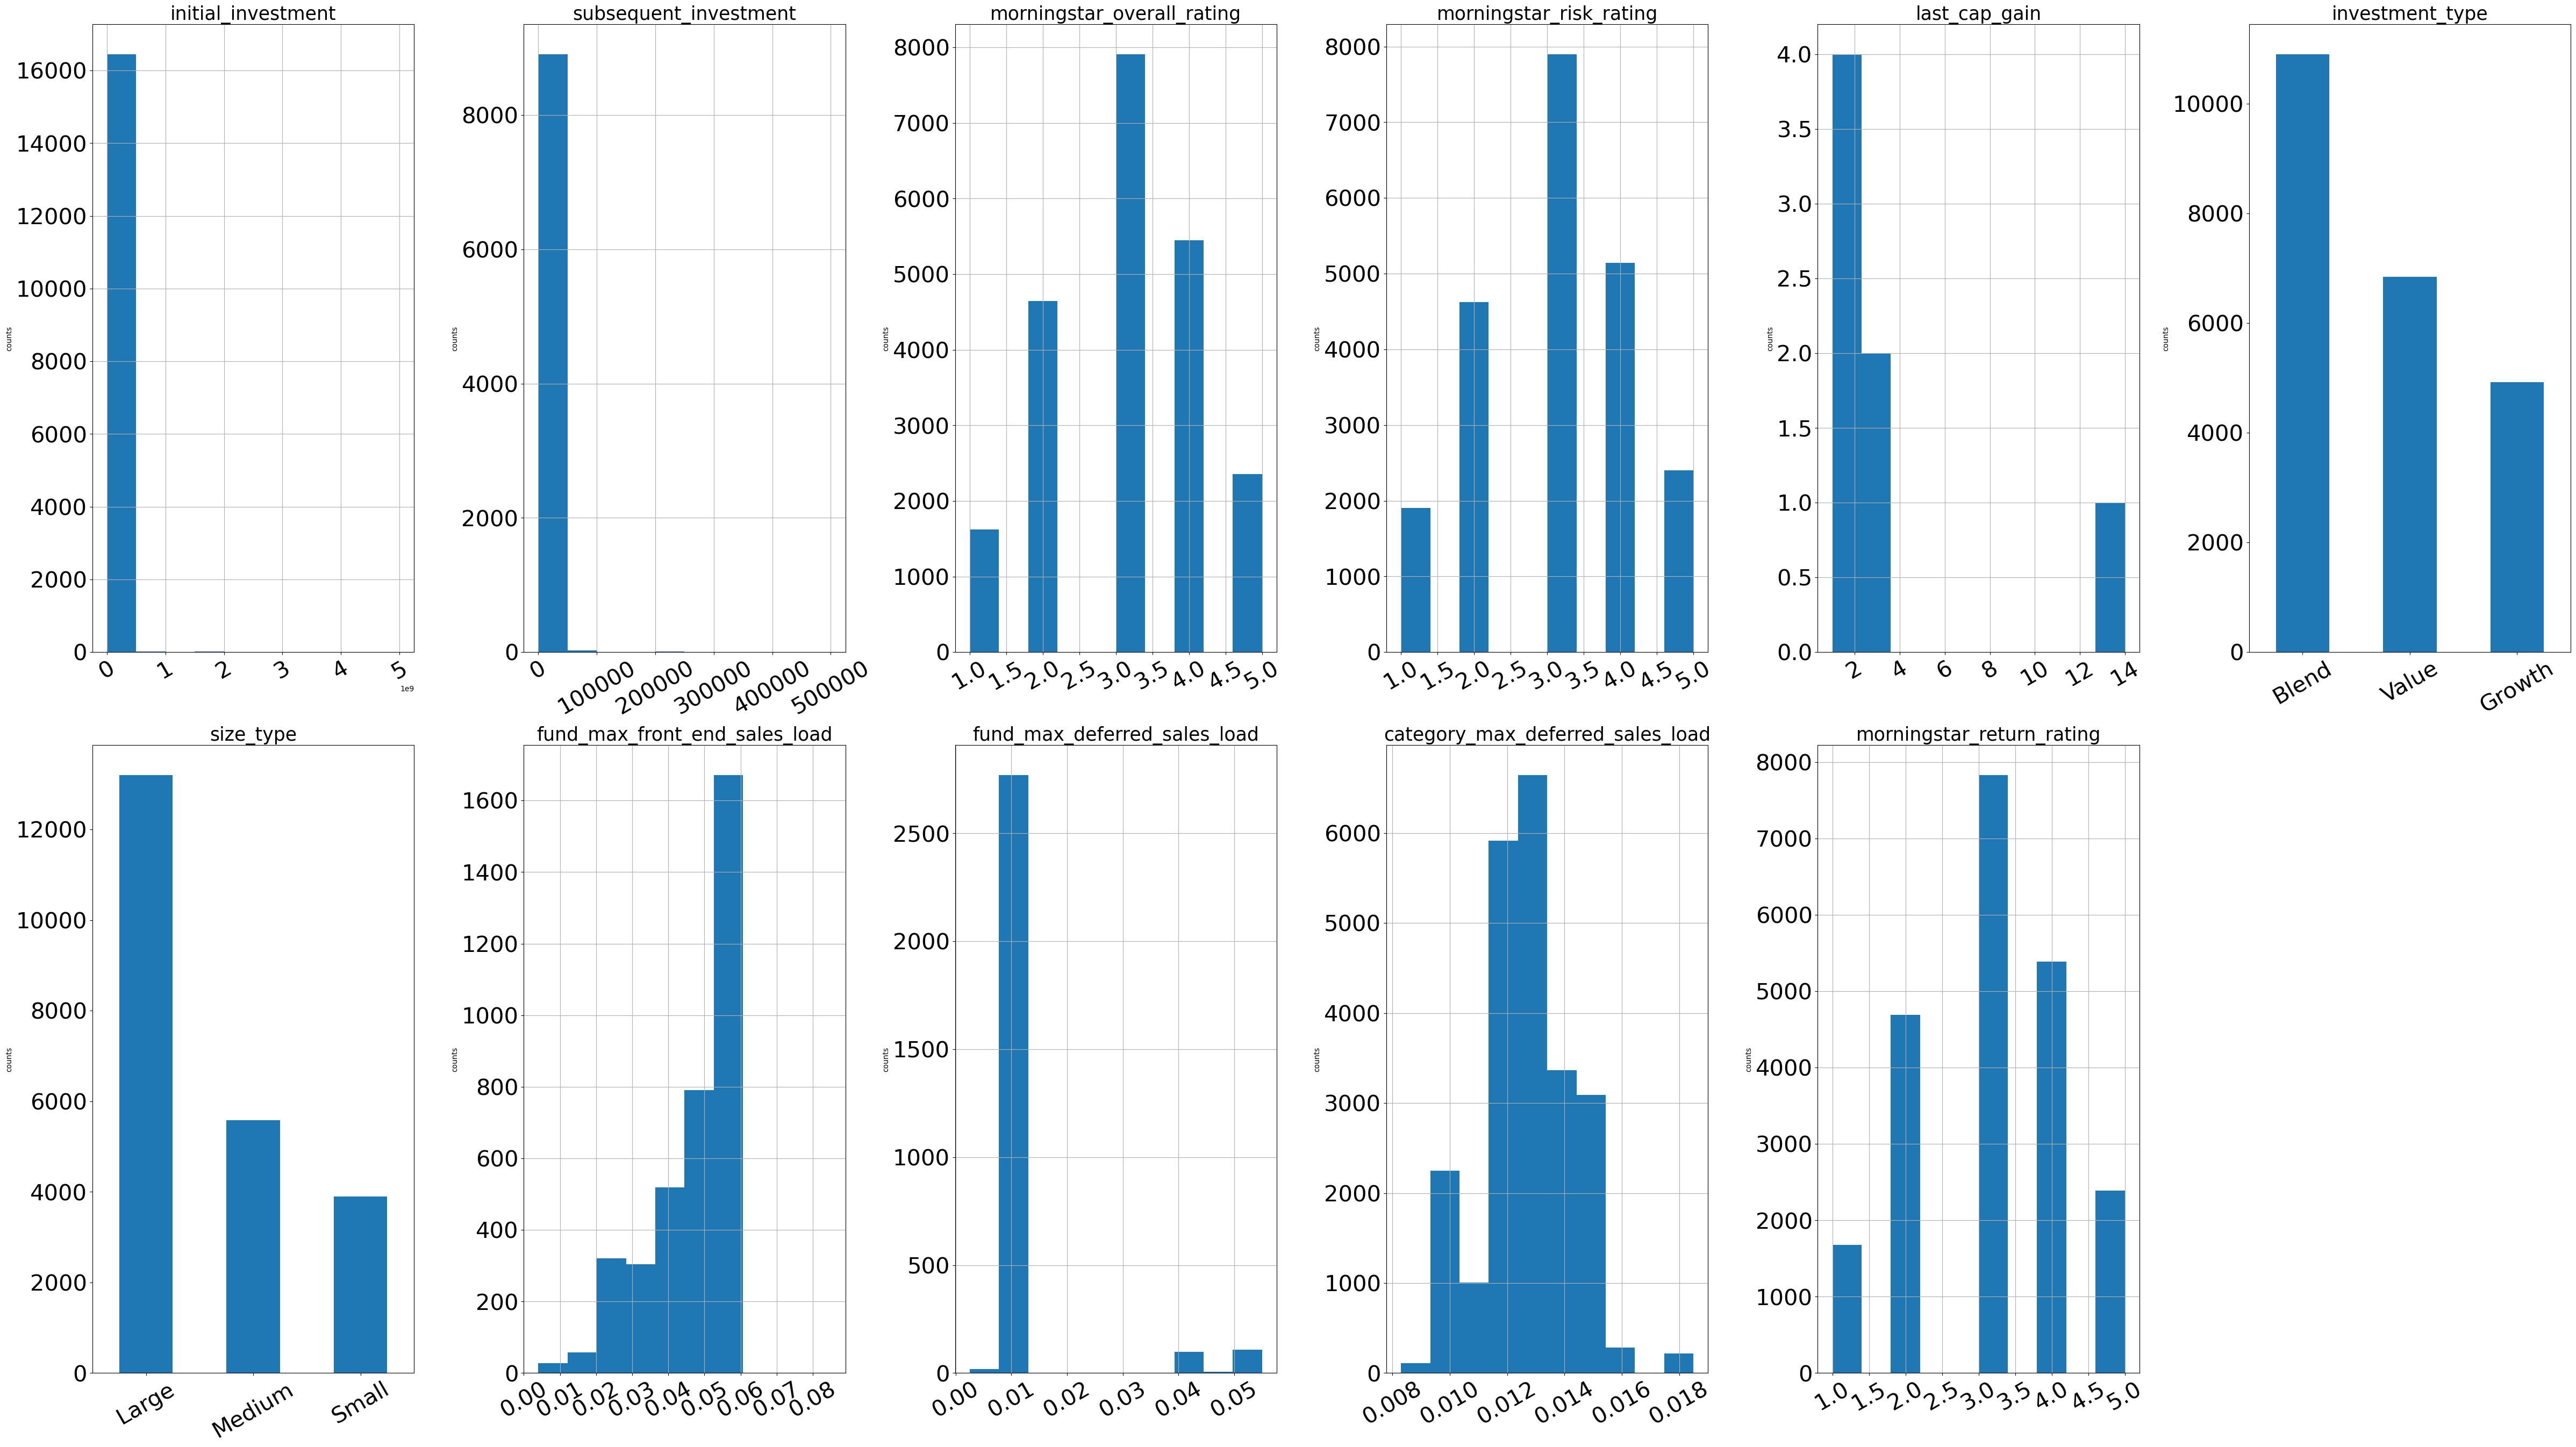

In [9]:
hist_bar_plot(df1)

In [18]:
def correlation_clean(df, threshold=(-0.9, -0.3, 0.3, 0.9)):
    """
    This dataset cleaning type reduces the number of 
    columns (attributes) that will be used in future
    analysis or model training. Reduction works by 
    focusing only on columns that have a greater 
    correlation (positive or negative) with other 
    columns. Having this, only high important attributes 
    are left to be utilized. 

    One of the reasons is that in large dimension datasets, 
    it takes too much time to train a model, and doesn't 
    guarantee that the model will have high accuracy. Also, 
    visualization in slow and through to understand in high 
    dimension datasets.
    
    Arguments:
        df: Dataset pandas DataFrame.
        threshold:  Threshold for choosing columns based 
        on correlation score.
    
    Returns:
        Cleaned dataset with high-correlated columns.
    """
    # Fix for non-numerical (or too many nan) columns
    col_corr = {
        # ETFs
        'fund_name', 'fund_extended_name', 'category', 'fund_family', 'net_assets', 'legal_type', 'investment', 'size',
        'currency', 'rating_us_government', 'fund_treynor_ratio_3years', 'category_treynor_ratio_5years',
    }
    try:
        for col in col_corr:
            del df[col]
    except KeyError:
        pass  # legal_type

    # Chose numerical columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (not threshold[0] <= corr_matrix.iloc[i, j] <= threshold[1] and
                not threshold[2] <= corr_matrix.iloc[i, j] <= threshold[3]
            ) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
                if colname in df.columns:
                    del df[colname]

    return df

In [19]:
def corr_mtx(df, fig_size=50, unique=True):
    """
    Correlation measures both the strength and direction of 
    the linear relationship between two variables. Depending 
    on the data, correlations could be calculated in a 
    couple of different ways. The most used way is to use 
    the Pearson product-moment correlation coefficient.
    
    Arguments:
        df: Dataset pandas DataFrame.
        fig_size: Size of the plot.
        unique: If True, it reduces the number of 
        attributes that will be visualized using 
        the number of unique values as a heuristic.
    """
    sns.set(font_scale=4.0)
    # Chose adequate columns for visualization
    if unique:
        num_unique_col = df.nunique()
        df = df[[col for col in df if num_unique_col[col] > 1]]

    f, ax = plt.subplots(figsize=(fig_size, fig_size))
    corr = df.corr()
    sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax)
    plt.show()
    sns.set(font_scale=2.0)

In [20]:
df1 = correlation_clean(df1, threshold=(-0.9, -0.6, 0.6, 0.9))

/var/folders/jn/4dmdznc1173g2hzcpmn5yck00000gn/T/ipykernel_1165/74628303.py:38: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


/var/folders/jn/4dmdznc1173g2hzcpmn5yck00000gn/T/ipykernel_1165/1982215804.py:23: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()
/var/folders/jn/4dmdznc1173g2hzcpmn5yck00000gn/T/ipykernel_1165/1982215804.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


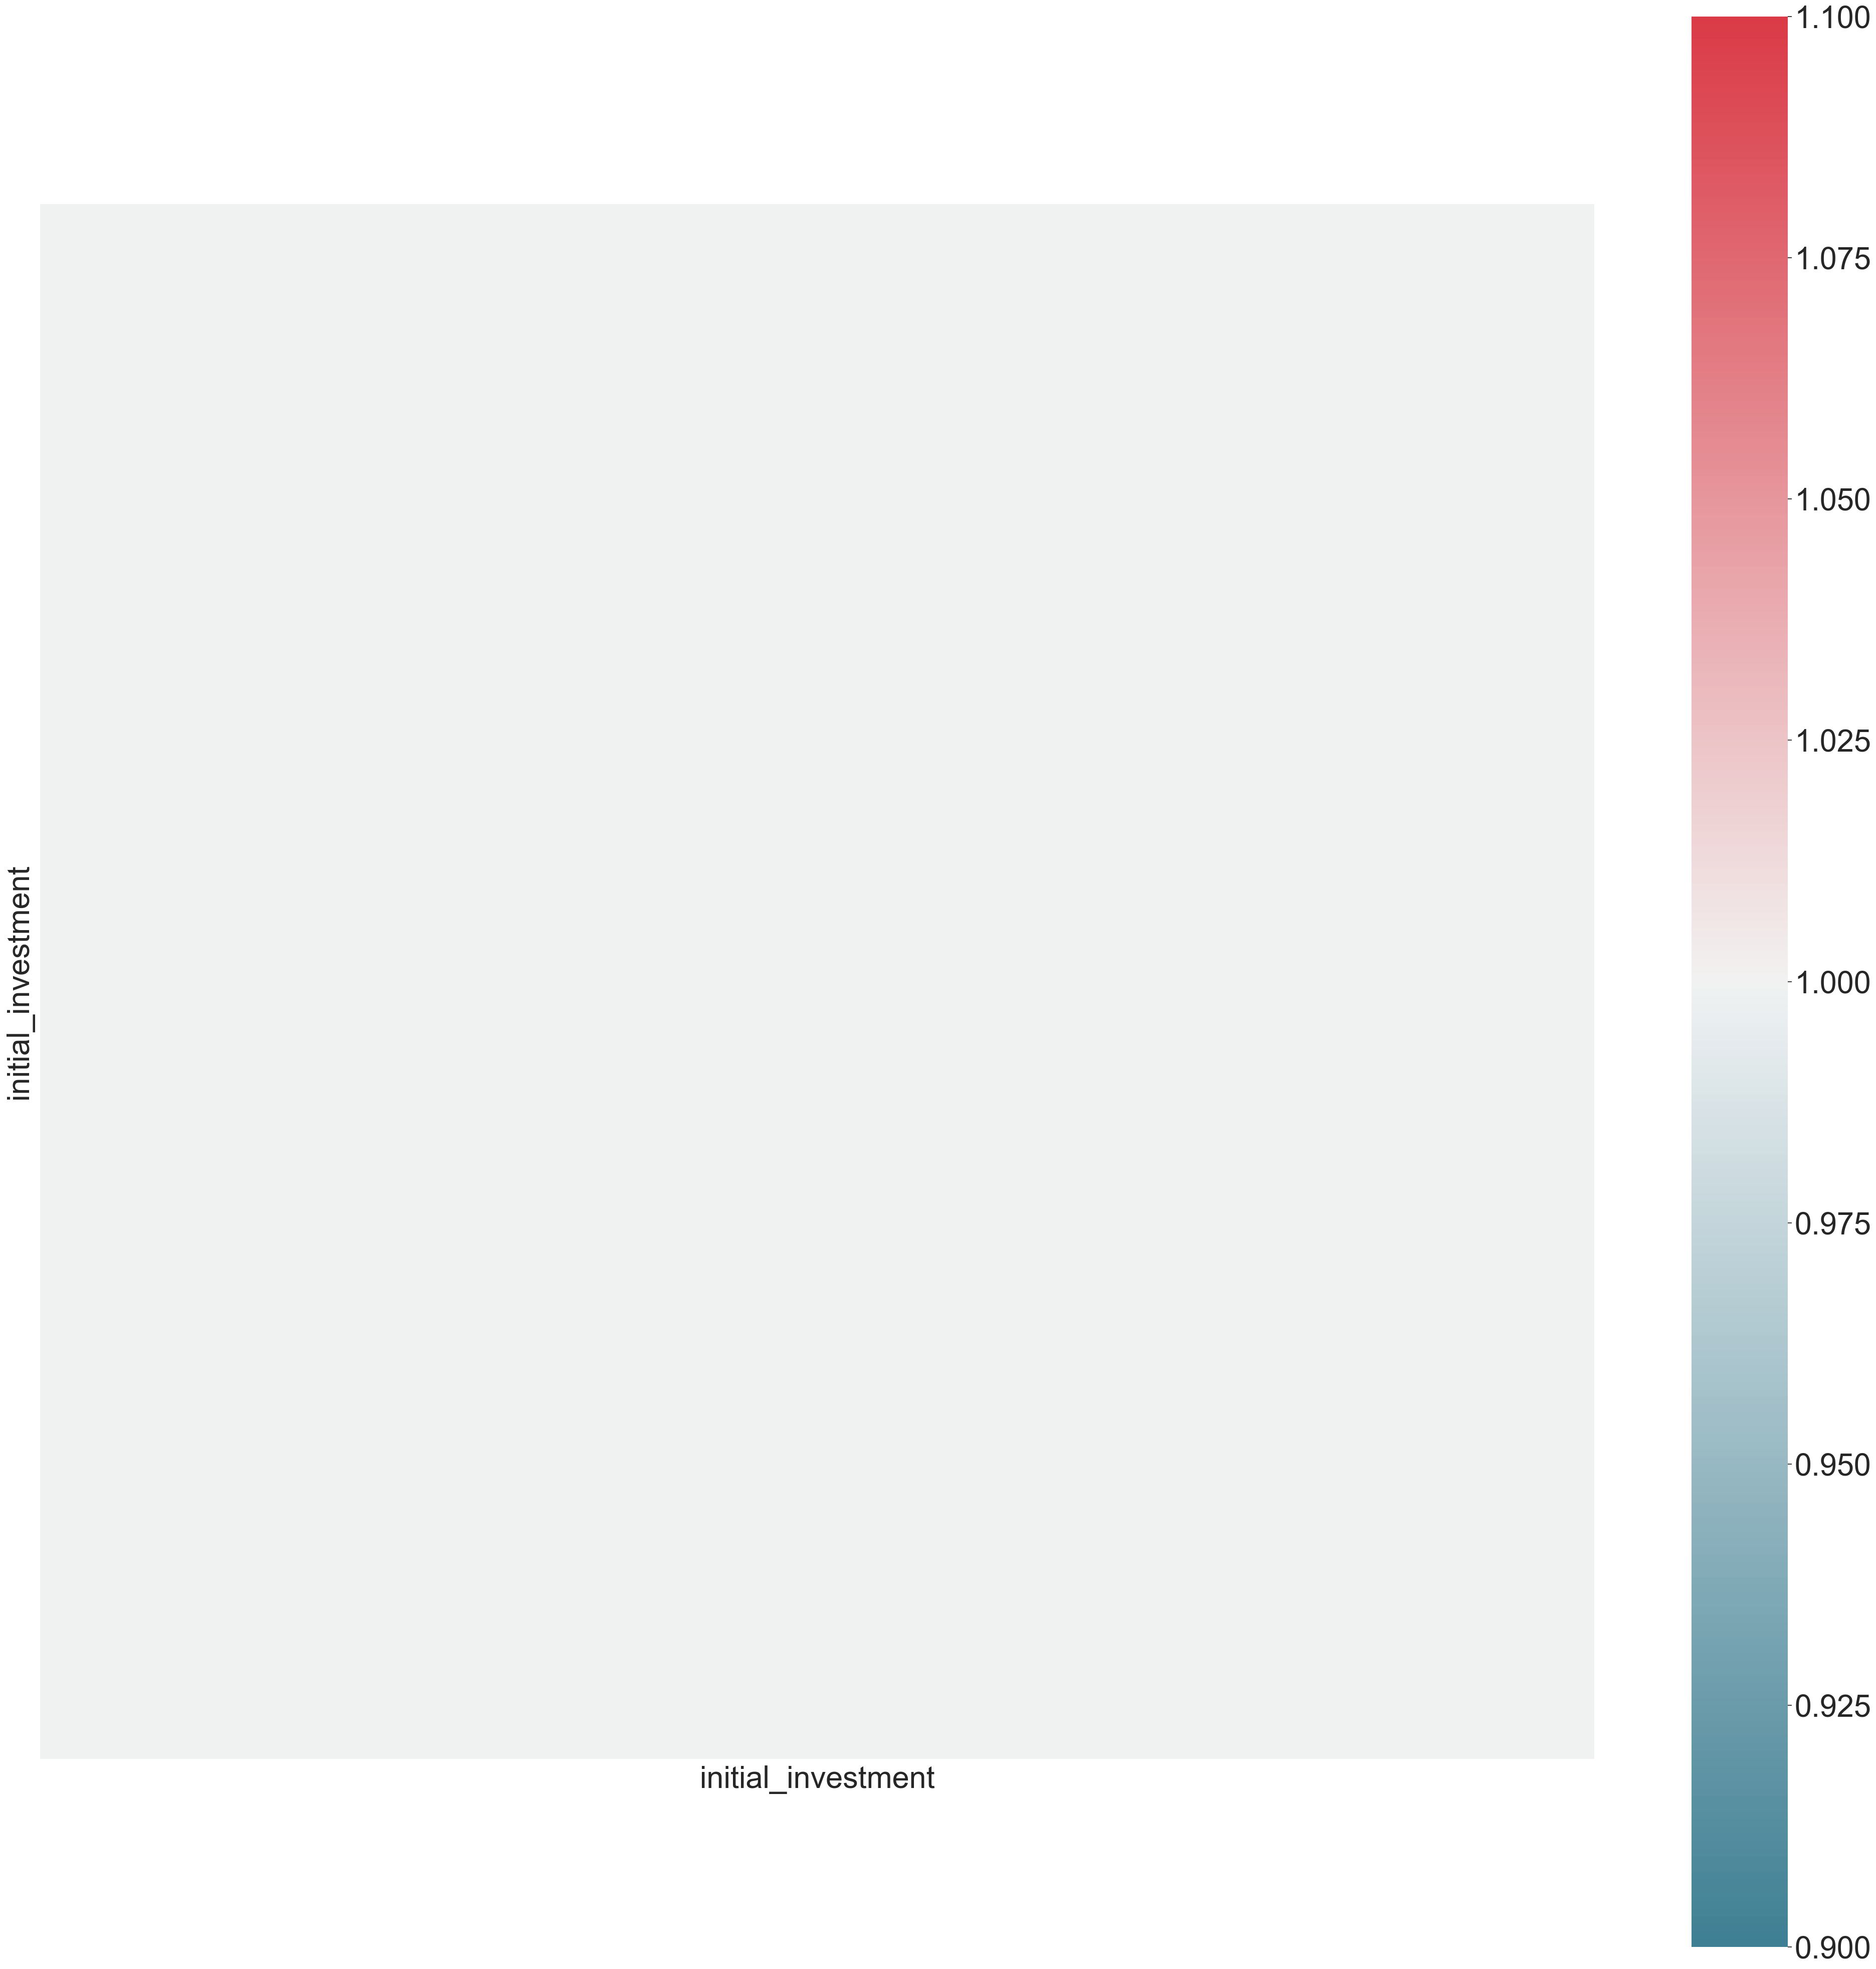

In [17]:
corr_mtx(df1, unique=False)

In [13]:
#check the shape of the dataset, how long and wide is it
df1.shape

(23783, 298)

In [14]:
#check which columns are included
df1.columns

Index(['fund_symbol', 'quote_type', 'region', 'fund_short_name',
       'fund_long_name', 'currency', 'initial_investment',
       'subsequent_investment', 'fund_category', 'fund_family',
       ...
       'peer_environment_avg', 'peer_environment_max', 'social_score',
       'peer_social_min', 'peer_social_avg', 'peer_social_max',
       'governance_score', 'peer_governance_min', 'peer_governance_avg',
       'peer_governance_max'],
      dtype='object', length=298)

In [ ]:
#check data types of columns
df1.dtypes

fund_symbol             object
quote_type              object
region                  object
fund_short_name         object
fund_long_name          object
                        ...   
peer_social_max        float64
governance_score       float64
peer_governance_min    float64
peer_governance_avg    float64
peer_governance_max    float64
Length: 298, dtype: object

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
df1.isnull().sum()

fund_symbol                                     0
quote_type                                      0
region                                          0
fund_short_name                               824
fund_long_name                                  5
currency                                        0
initial_investment                           7298
subsequent_investment                       14840
fund_category                                 663
fund_family                                     0
exchange_code                                   0
exchange_name                                   0
exchange_timezone                               0
management_name                                 0
management_bio                                479
management_start_date                           0
total_net_assets                               34
year_to_date_return                           401
day50_moving_average                            1
day200_moving_average                           1


In [ ]:
# check for number of unique values in each column
df1.nunique()

fund_symbol                                 23783
quote_type                                      1
region                                          1
fund_short_name                              3044
fund_long_name                               6644
currency                                        1
initial_investment                             48
subsequent_investment                          20
fund_category                                 119
fund_family                                   310
exchange_code                                   1
exchange_name                                   1
exchange_timezone                               1
management_name                              1388
management_bio                               1300
management_start_date                        2316
total_net_assets                             7173
year_to_date_return                          3956
day50_moving_average                        15870
day200_moving_average                       15705


In [ ]:
# drop columns quote_type ,region ,currency ,exchange_code ,exchange_name ,exchange_timezone ,fund_bonds_us_government 

df1.drop(['quote_type','region','currency','exchange_code','exchange_name','exchange_timezone','fund_bonds_us_government'],axis=1,inplace=True)

In [ ]:
df1.isnull().sum().sort_values(ascending=False)

last_cap_gain                               23776
fund_return_2021_q3                         23721
fund_max_deferred_sales_load                20780
fund_return_2021_q2                         20166
fund_max_front_end_sales_load               20090
fund_return_2000                            19827
fund_return_2000_q4                         19827
fund_return_2000_q3                         19734
fund_return_2000_q2                         19599
fund_return_2000_q1                         19462
fund_return_2001                            19278
fund_return_2001_q4                         19278
fund_return_2001_q3                         19051
fund_return_2001_q2                         18926
fund_return_2001_q1                         18797
fund_return_2002_q4                         18676
fund_return_2002                            18673
fund_return_2002_q3                         18509
fund_return_2002_q2                         18322
fund_return_2002_q1                         18159


In [16]:
# define a new coloumn called esg_ranking based on esg_score column and sort values in descending order---method min

df1['esg_ranking']=df1['esg_score'].rank(ascending=False, method='min')

# show me the output of esg_ranking column and esg_score column and fund_symbol column in descending order-- 
df1[['esg_ranking','esg_score','fund_symbol']].sort_values(by='esg_ranking',ascending=True).head(30)

,esg_ranking,esg_score,fund_symbol
19268,1.0,41.21,RSNRX
19269,1.0,41.21,RSNYX
19267,1.0,41.21,RSNKX
18772,1.0,41.21,RGNCX
8346,5.0,40.97,GRHIX
8345,5.0,40.97,GRHAX
16002,7.0,40.05,OSPMX
20446,7.0,40.05,SPMQX
20449,7.0,40.05,SPNNX
13905,7.0,40.05,MLPZX


In [29]:
#columns to keep:
#fund_symbol	
#fund_short_name	short name of the fund
#fund_long_name	extended name of the fund
#fund_category	name of the fund category (i.e. Large Blend, Large Growth, Large Value
#fund_family	name of the fund family, i.e. BlackRock, Fidelity
#total_net_assets	total net assets (abbreviated as TNA or NAV) of the fund
#year_to_date_return	year-to-date return (YTD - calculated from first day of the year up to latest price)
#day200_moving_average	
#week52_high_low_change_percentage	relative change (in %) of price in latest 52 weeks
#morningstar_overall_rating	overall MorningStar rating
#fund_yield	fund yield (income amount per share divided by the share's NAV)
#inception_date	date of fund inception (in 'YYYY-MM-DD' format)
#investment_type	type of investment (value, blend, or growth)
#size_type	type of size (small, medium, or large)type of size (small, medium, or large)
#fund_return_10years	10-years fund return
#fund_mean_annual_return_10years	10-years fund mean annual return
#fund_annual_report_net_expense_ratio	actual fees charged by the fund during a particular fiscal year
#fund_alpha_10years	10-years fund alpha (volatility in comparison with the market as a whole)
#fund_beta_10years	10-years fund beta (volatility in comparison with the market as a whole)
#fund_sharpe_ratio_10years	10-years fund Sharpe ratio
#esg_score	fund ESG score (Environmental, Social, Government)
#esg_peer_group	name of ESG peer group
#peer_esg_avg	average ESG score in peer group
#environment_score	fund Environmental score
#peer_environment_avg	average Environmental score in peer group
#social_score	fund Social score
#peer_social_avg	average Social score in peer group
#governance_score	fund Government score
#peer_governance_avg	average Government score in peer group
#fund_sector_basic_materials	holdings allocation (in %) securities that belong to the basic materials sector
#fund_sector_communication_services	holdings allocation (in %) securities that belong to the communication services sector
#fund_sector_consumer_cyclical	holdings allocation (in %) securities that belong to the consumer cyclical sector (e.g. Automobiles, Hotels, Restaurants, and Leisure)
#fund_sector_consumer_defensive	holdings allocation (in %) securities that belong to the consumer defensive sector (products and services are considered essential or necessary for daily living)
#fund_sector_energy	holdings allocation (in %) securities that belong to the energy sector
#fund_sector_financial_services	holdings allocation (in %) securities that belong to the financial service sector
#fund_sector_healthcare	
#fund_sector_industrials	holdings allocation (in %) securities that belong to the industrials sector
#fund_sector_real_estate	
#fund_sector_technology	
#fund_sector_utilities


columns_to_keep = ['fund_symbol', 'fund_short_name','fund_long_name','fund_category','fund_family', 'total_net_assets', 
                   'year_to_date_return','day200_moving_average','week52_high_low_change_perc',
                   'morningstar_overall_rating','fund_yield','inception_date','investment_type',
                   'size_type','fund_return_10years','fund_mean_annual_return_10years',
                   'fund_annual_report_net_expense_ratio','fund_alpha_10years','fund_beta_10years',
                   'fund_sharpe_ratio_10years','esg_score','esg_peer_group','peer_esg_avg',
                   'environment_score','peer_environment_avg','social_score','peer_social_avg',
                   'governance_score','peer_governance_avg','fund_sector_basic_materials',
                   'fund_sector_communication_services','fund_sector_consumer_cyclical',
                   'fund_sector_consumer_defensive','fund_sector_energy','fund_sector_financial_services',
                   'fund_sector_healthcare','fund_sector_industrials','fund_sector_real_estate',
                   'fund_sector_technology','fund_sector_utilities']

# Build dataframe including only the columns you want to keep

mutual_fund_subset= df1.loc[:,columns_to_keep]

In [32]:
# Define the weights for each variable
weight_return = 30
weight_yield = 30
weight_alpha = 10
weight_sharpe = 10
weight_beta = 10
weight_fees = 10

# Calculate the financial score
mutual_fund_subset['financial_score'] =(weight_return * mutual_fund_subset['fund_mean_annual_return_10years'])
+(weight_yield * mutual_fund_subset['fund_yield'])
+(weight_alpha * mutual_fund_subset['fund_alpha_10years'])
+(weight_sharpe * mutual_fund_subset['fund_sharpe_ratio_10years'])
- (weight_beta * mutual_fund_subset['fund_beta_10years'])
- (weight_fees * mutual_fund_subset['fund_annual_report_net_expense_ratio'])

# Print the resulting DataFrame
mutual_fund_subset.head()

,fund_symbol,fund_short_name,fund_long_name,fund_category,fund_family,total_net_assets,year_to_date_return,day200_moving_average,week52_high_low_change_perc,morningstar_overall_rating,...,fund_sector_consumer_cyclical,fund_sector_consumer_defensive,fund_sector_energy,fund_sector_financial_services,fund_sector_healthcare,fund_sector_industrials,fund_sector_real_estate,fund_sector_technology,fund_sector_utilities,financial_score
0,AAAAX,DWS RREEF Real Assets Fund - Cl,DWS RREEF Real Assets Fund - Class A,World Allocation,DWS,2.979347e+09,0.21026,12.369,0.18683,3.0,...,0.0190,0.0293,0.1852,0.0000,0.0000,0.1413,0.3520,0.0012,0.1025,12.6
1,AAAEX,AllianzGI Health Sciences Fund,Virtus AllianzGI Health Sciences Fund Class P,Health,Virtus,1.953489e+08,0.19077,38.650,0.20256,3.0,...,0.0034,0.0000,0.0000,0.0000,0.9598,0.0000,0.0000,0.0000,0.0000,35.4
2,AAAFX,NaN,American Century One Choice Blend+ 2015 Portfo...,Target-Date 2015,American Century Investments,2.594600e+04,NaN,10.392,0.07096,NaN,...,0.1184,0.0822,0.0355,0.1679,0.1342,0.1277,0.0376,0.1696,0.0258,NaN
3,AAAGX,Thrivent Large Cap Growth Fund,Thrivent Large Cap Growth Fund Class A,Large Growth,Thrivent Funds,2.078607e+09,0.24559,17.294,0.23955,4.0,...,0.1957,0.0046,0.0000,0.1458,0.1326,0.0346,0.0000,0.3250,0.0000,42.0
4,AAAHX,NaN,American Century One Choice Blend+ 2015 Portfo...,Target-Date 2015,American Century Investments,2.594600e+04,NaN,10.398,0.07183,NaN,...,0.1184,0.0822,0.0355,0.1679,0.1342,0.1277,0.0376,0.1696,0.0258,NaN


In [33]:
mutual_fund_subset.isnull().sum()

fund_symbol                                 0
fund_short_name                           824
fund_long_name                              5
fund_category                             663
fund_family                                 0
total_net_assets                           34
year_to_date_return                       401
day200_moving_average                       1
week52_high_low_change_perc               287
morningstar_overall_rating               1807
fund_yield                               5097
inception_date                              0
investment_type                          1109
size_type                                1109
fund_return_10years                     11346
fund_mean_annual_return_10years          7079
fund_annual_report_net_expense_ratio      210
fund_alpha_10years                       7114
fund_beta_10years                        7080
fund_sharpe_ratio_10years                7089
esg_score                                8376
esg_peer_group                    

In [43]:
from sql_functions import get_engine
import sqlalchemy 
from sql_functions import get_dataframe 



In [41]:
# create a variable called engine using the get_engine function
engine = get_engine()

# Set the schema to your course name and the table_name variable to 'carriers_' + your initials/group number
#schema = '______' # your course schema name, example 'hh_analytics_22_1
schema = 'capstone_esg_investment'
#table_name = '_____' # Example: 'carriers_pw' for Philipp Wendt
table_name = 'mutual_funds_subset'

# we need psycopg2 for raising possible error message
import psycopg2

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        mutual_fund_subset.to_sql(name = table_name, # Name of SQL table variable
                        con = engine, # Engine or connection
                        schema = schema, # your class schema variable
                        if_exists = 'replace', # Drop the table before inserting new values
                        index = False, # Write DataFrame index as a column
                        chunksize = 5000, # Specify the number of rows in each batch to be written at a time
                        method = 'multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
else:
    print('No engine')

NameError: name 'get_engine' is not defined

In [7]:
df3 = pd.read_excel('~/Desktop/neue_fische/capstone_project/ESG mandated assets.xlsx', header=0)

In [ ]:
# Use predefined style ggplot
plt.style.use('ggplot') 

# Set figure size
plt.figure(figsize=(6, 4))

# Create histogram by specifying x-value
plt.hist(x = df3['quality'], bins = 10)

# Label your axes
plt.xlabel("Quality")
plt.ylabel("Frequency")

# Set title
plt.title("Distribution of Red Wine quality")

# Show graphic
plt.show()

In [22]:
df_mutual = pd.read_csv('/Users/isidorakujundzic/Project-description/data/MutualFund prices - A-E.csv')
df_mutual1 = pd.read_csv('/Users/isidorakujundzic/Project-description/data/MutualFund prices - F-K.csv')
df_mutual3 = pd.read_csv('/Users/isidorakujundzic/Project-description/data/MutualFund prices - L-P.csv')
df_mutual4 = pd.read_csv('/Users/isidorakujundzic/Project-description/data/MutualFund prices - Q-Z.csv')

In [24]:
#merge all the mutual fund prices into one dataframe
df_mutual_price=pd.concat([df_mutual, df_mutual1, df_mutual3, df_mutual4],axis=0)
df_mutual_price.head()

,fund_symbol,price_date,nav_per_share
0,AAAAX,2007-07-31,10.02
1,AAAAX,2007-08-01,9.98
2,AAAAX,2007-08-02,10.01
3,AAAAX,2007-08-03,9.90
4,AAAAX,2007-08-06,9.93


In [28]:
df_mutual_price['price_date'] = pd.to_datetime(df_mutual_price['price_date'])

In [33]:
start_date = pd.to_datetime('2011-01-01')
end_date = pd.to_datetime('2021-12-31')
filtered_df = df_mutual_price[(df_mutual_price['price_date'] >= start_date) & (df_mutual_price['price_date'] <= end_date)]

In [35]:
filtered_df = filtered_df.sort_values('price_date', ascending=True)
filtered_df.head(20)

,fund_symbol,price_date,nav_per_share,price date
14784067,PAXHX,2011-01-03,7.76,2011-01-03
6383573,MINSX,2011-01-03,12.85,2011-01-03
13141676,UMEMX,2011-01-03,11.63,2011-01-03
16148390,PFIIX,2011-01-03,9.10,2011-01-03
6766780,BTIAX,2011-01-03,21.94,2011-01-03
6605939,FTCZX,2011-01-03,13.79,2011-01-03
9813176,CPHYX,2011-01-03,7.98,2011-01-03
19287213,JSMIX,2011-01-03,15.14,2011-01-03
15702469,VTWIX,2011-01-03,98.12,2011-01-03
8364421,STFBX,2011-01-03,54.30,2011-01-03


In [36]:
filtered_df = filtered_df.reset_index(drop=True)
filtered_df.head()

,fund_symbol,price_date,nav_per_share,price date
0,PAXHX,2011-01-03,7.76,2011-01-03
1,MINSX,2011-01-03,12.85,2011-01-03
2,UMEMX,2011-01-03,11.63,2011-01-03
3,PFIIX,2011-01-03,9.10,2011-01-03
4,BTIAX,2011-01-03,21.94,2011-01-03


In [ ]:
import

In [44]:
# create a variable called engine using the get_engine function
engine = get_engine()

# Set the schema to your course name and the table_name variable to 'carriers_' + your initials/group number
#schema = '______' # your course schema name, example 'hh_analytics_22_1
schema = 'capstone_esg_investment'
#table_name = '_____' # Example: 'carriers_pw' for Philipp Wendt
table_name = 'filtered_df'

# we need psycopg2 for raising possible error message
import psycopg2

# Write records stored in a dataframe to SQL database
if engine!=None:
    try:
        filtered_df.to_sql(name = table_name, # Name of SQL table variable
                        con = engine, # Engine or connection
                        schema = schema, # your class schema variable
                        if_exists = 'replace', # Drop the table before inserting new values
                        index = False, # Write DataFrame index as a column
                        chunksize = 5000, # Specify the number of rows in each batch to be written at a time
                        method = 'multi') # Pass multiple values in a single INSERT clause
        print(f"The {table_name} table was imported successfully.")
    # Error handling
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        engine = None
else:
    print('No engine')

The filtered_df table was imported successfully.


In [37]:
earliest_price = df_mutual_price['nav_per_share'].iloc[0]
latest_price = df_mutual_price['nav_per_share'].iloc[-1]
price_change = ((latest_price - earliest_price) / earliest_price) * 100

In [38]:
print("ROI: {:.2f}%".format(price_change))

ROI: 266.38%
